In [56]:
import itertools as it
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d

In [11]:
# Standard
root = Path()
sample_df = pd.DataFrame()
for experiment in (root / "experiments" / "measure").glob("*"):
    with open(experiment / "config.json") as f:
        config = json.load(f)

    _sample_df = pd.read_feather(experiment / "sample_df.feather")
    _sample_df["size"] = config["size"]
    _sample_df["algorithm"] = config["algorithm"]

    sample_df = pd.concat([sample_df, _sample_df])

In [75]:
# Find crossings
from scipy import optimize

sample_df["id"] = (
    "N" + sample_df["size"].astype(str) + "_" + sample_df["state_id"].astype(str)
)


# Set up interpolations
def get_interp(group):
    return interp1d(
        group["natural_temperature"],
        group["binder_4"],
        kind="linear",
        # fill_value="extrapolate",
    )


interps = (
    sample_df.query("1.00 <= natural_temperature <= 1.25")
    .groupby("size")
    .apply(get_interp)
    .tolist()
)

crossings = []
for interp1, interp2 in it.combinations(interps, 2):
    difference = lambda x: interp1(x) - interp2(x)
    root_sol = optimize.root_scalar(difference, x0=1.13, x1=1.14, bracket=(1.1, 1.15))
    assert root_sol.converged

    crossings.append(root_sol.root)

T_c = np.mean(crossings)
T_c_sd = np.std(crossings)

print(f"{T_c}±{T_c_sd}")
print(1 / (1 * np.log(1 + np.sqrt(2))))

1.1327312526188957±0.0005822205089690086
1.134592657106511


[(1.0, 1.2), (-0.02, 0.01)]

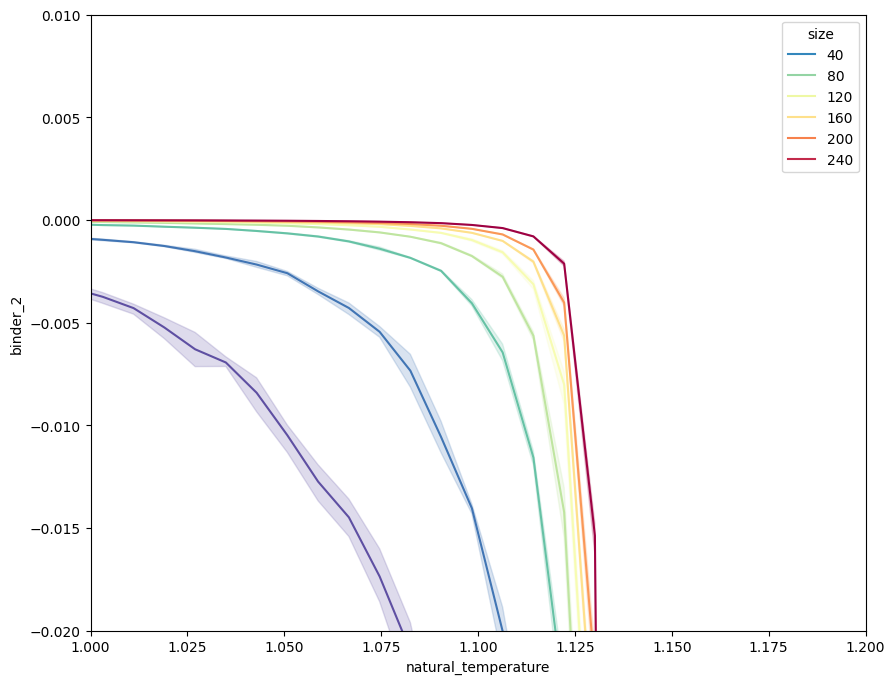

In [39]:
fig = plt.figure()
fig.set_size_inches(10, 8)
ax = sns.lineplot(
    data=sample_df,
    x="natural_temperature",
    y="binder_2",
    hue="size",
    palette="Spectral_r",
)
ax.set(xlim=(1.0, 1.2), ylim=(-0.1, 0.01))

[(1.1, 1.16), (-0.1, -0.03)]

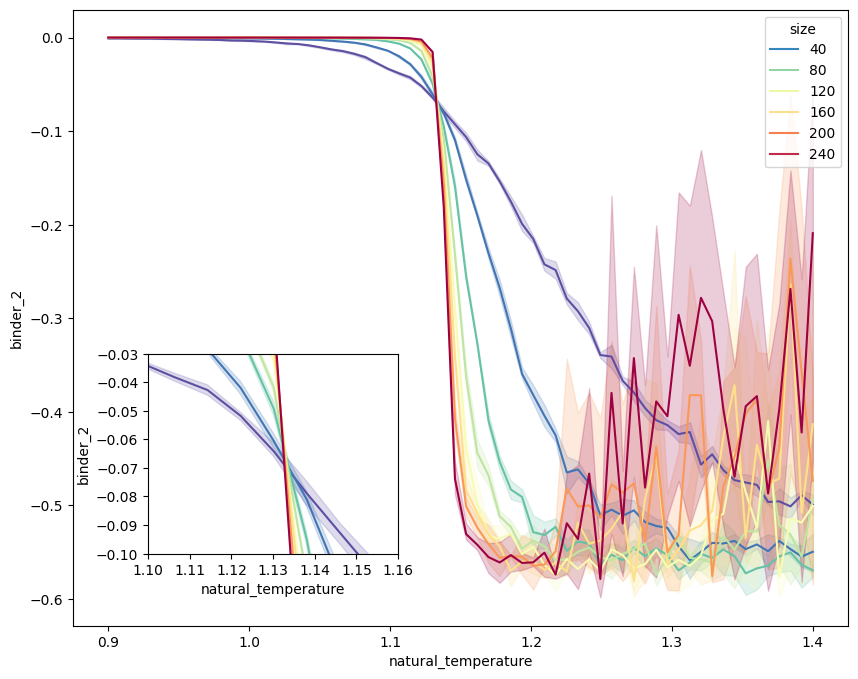

In [18]:
fig = plt.figure()
fig.set_size_inches(10, 8)
ax = sns.lineplot(
    data=sample_df,
    x="natural_temperature",
    y="binder_2",
    hue="size",
    palette="Spectral_r",
)

ax2 = plt.axes([0.2, 0.2, 0.25, 0.25])
sns.lineplot(
    ax=ax2,
    data=sample_df,
    x="natural_temperature",
    y="binder_2",
    hue="size",
    palette="Spectral_r",
)
ax2.get_legend().remove()

# ax2.set(xlim=(1.1, 1.16), ylim=(-0.1, -0.03))